# Finding Cycles in NFT Transactions

## Overview

A Non-fungible Token (NFT) is a digital asset which cannot be copied, substituted, or subdivided, meaning it is wholly unique.

![title](http://web.archive.org/web/20220328080727im_/https://blog.portion.io/content/images/2021/07/Kevin-McCoy-Quantum.gif)

NFT’s are stored on blockchain systems, notably Ethereum, with the owner of an NFT being whomever has access to the wallet it is stored within.

Since the first NFT, Quantum (shown above), many new NFT artworks have arisen including Cryptokitties and Cryptopunks. This culminated in a boom in 2021 which included the arrival of the Bored Ape Yacht Club, with NFTS reaching a global market valued of $15.7 Billion.

In this example we will analyse an NFT dataset in order to find suspicious trading cycles.

1. Using Raphtory to load the NFT data as a graph
2. Execute a cycle detection algorithm
3. Analyse the results to find suspicious cycles of NFTs

The data we used is a cleaned and trimmed version from [1]


[1] Nadini, M., Alessandretti, L., Di Giacinto, F. et al. Mapping the NFT revolution: market trends, trade networks, and visual features. Sci Rep 11, 20902 (2021). https://doi.org/10.1038/s41598-021-00053-8

## Loading data with Raphtory

First we install some extra packages

In [ ]:
%pip install pandas tqdm seaborn

Now we import the following so we can use Raphtory

In [2]:
from raphtory import Graph
from raphtory import algorithms

from nft_helper import *

import pandas as pd
import os 
from tqdm.notebook import tqdm
from calendar import timegm
import datetime
import time
import re
import os

Below are our data sources
- `date_price` a dictionary containing the daily ETH-USD price, we we need to convert as some prices are missing
- `filename` - this is the cleaned transaction data, which represents NFTs being bought by wallets 
- `at_time` - is the time we want to run our analysis, this is the last time in the dataset 

In [62]:
if not os.path.isfile("ETH-USD.csv"):
    !curl -o ETH-USD.csv https://osf.io/download/mw3vh/ -L
    
if not os.path.isfile("Data_API.csv"):
    !curl -o Data_API.csv https://osf.io/download/jpz2e/ -L

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   387  100   387    0     0    564      0 --:--:-- --:--:-- --:--:--   574
  0     0    0     0    0     0      0      0 --:--:--  0:00:02 --:--:--     0
100  106M  100  106M    0     0  7323k      0  0:00:14  0:00:14 --:--:-- 8794k 0:00:15  0:00:14  0:00:01 8864k


Set up the variables

In [4]:
eth_price_csv = 'ETH-USD.csv'
print("Loading ETH-USD.csv")
date_price = setup_date_prices(eth_price_csv)

print("Loading Data_API.csv")
filename = "Data_API.csv"
data_df = pd.read_csv(filename)

at_time = 1561661534

Loading ETH-USD.csv
Loading Data_API.csv


/var/folders/rm/nnz28pc96cv2xqzbwlwvwl2r0000gn/T/ipykernel_29037/2545216830.py:7: DtypeWarning: Columns (0,4,6) have mixed types. Specify dtype option on import or set low_memory=False.
  data_df = pd.read_csv(filename)


For this example, we are going to create a bipartite graph. 

In our graph, we have wallets on the left, and NFTs on the right. 

Each edge represents that an NFT was purchased by a wallet. 

The `parse_graph` function will take each line, from the spout, and turn these into graph updates. 


![title](https://www.raphtory.com/images/nfts/buy_nft.png)


In [72]:
import csv
def load_or_create_graph_csv(graph_name='/tmp/nft_graph', filename='Data_API.csv'):
    if os.path.exists(graph_name):
        return Graph.load_from_file(graph_name)
    else:
        g = Graph()
        with open(filename, encoding='utf-8') as f:
            reader = csv.reader(f)
            header = next(reader)
            for row in tqdm(reader, total=359219):
                timestamp = int(row[13])
                # NFT details + nft node
                v_props = {
                    'type': 'NFT', 
                    'collection': row[14], 
                    'category': row[15]
                }
                g.add_vertex(0, row[1], v_props)
                # Buyer details + buyer node
                g.add_vertex(0, row[5], {'type': 'buyer'})
                # Transaction details
                # Creating a bipartite graph,
                # add edge between buyer and nft
                price = 0.0
                if row[9] != '':
                    price = float(row[9])
                properties = {
                    "price_usd": price, 
                    "timestamp": timestamp, 
                    "transaction_hash": row[2]
                }
                g.add_edge(timestamp, row[5], row[1], properties)
        return g

Now we will start a raphtory instance and load our data

In [73]:
g = load_or_create_graph_csv()

  0%|          | 0/359219 [00:00<?, ?it/s]

## Executing a Cycle detection algorithm

Below is a visual representation of the cycle detection. 

This is when a NFT has been sold by a wallet, but eventually ends up being owned by it again. This can involve a chain of any number of other wallets, take any amount of time, and increase or decrease the price by any amount.

Below we can see an example of such a cycle where Wallet A sold an NFT to Wallet B for $50$ on Monday, but its back in their position by Thursday, costing them $750$. They either have serious sellers remorse or, more likely, the same person owns all these wallets and is trying to pump up the price of the given NFT.

Our algorithm:
- Gets each NFT
- For each time it was purchased, checks the list of purchases to see if a user re-bought the NFT at a later date, at a higher price

This all happens within the `step` function. A `step` is executed once on each node.  

The code has been optimised to O(n) complexity. 

![title](https://www.raphtory.com/images/nfts/NFT_Cycle.png)

In [74]:
def money_cycle_algorithm(g):
    all_cycles_dict = {}
    for v in tqdm(g.vertices()):
        if v['type'] != "NFT":
            continue
        all_cycles = []
        all_purchases = sorted(list(v.in_edges().explode()), key = lambda e: e['timestamp'])
        purchasers = list(map(lambda e:
                          dict(price_usd=float(e["price_usd"]),
                               nft_id=e.dst().name(),
                               tx_hash=e["transaction_hash"],
                               time=e['timestamp'],
                               buyer=e.src().name()),
                          all_purchases))
        if len(purchasers) > 2:
            buyers_seen = {}
            for pos, item_sale in enumerate(purchasers):
                buyer_id = item_sale['buyer']
                if buyer_id not in buyers_seen:
                    buyers_seen[buyer_id] = pos
                else:
                    prev_pos = buyers_seen[buyer_id]
                    prev_price = purchasers[prev_pos]['price_usd']
                    current_price = item_sale['price_usd']
                    buyers_seen[buyer_id] = pos
                    if prev_price < current_price:
                        all_cycles.append(purchasers[prev_pos:pos + 1])
        if len(all_cycles):
            all_cycles_dict[v] = all_cycles
    return all_cycles_dict

def save_to_csv(data):
    header = ["nft_id", "nft_collection", "nft_category", "cycle_lengths", "cycle_info"]
    all_rows = []
    for k,cycles_found in data.items():
        nft_id = k.name()
        nft_collection = k['collection']
        nft_category = k['category']
        cycle_lengths = [len(cycle) for cycle in cycles_found]
        cycle_info = [dict(cycle={'sales': single_cycle},
                                               profit_usd=float(single_cycle[len(single_cycle) - 1]['price_usd']) -
                                                          float(single_cycle[0]['price_usd']),
                                               buyer=str(single_cycle[0]['buyer'])) for single_cycle in cycles_found]
        rows_found = list(map(lambda single_cycle:
                      [
                          nft_id,
                          nft_collection,
                          nft_category,
                          len(single_cycle),
                          dict(cycle={'sales': single_cycle},
                               profit_usd=float(single_cycle[len(single_cycle) - 1]['price_usd']) -
                                          float(single_cycle[0]['price_usd']),
                               buyer=str(single_cycle[0]['buyer']))
                      ], cycles_found))
        all_rows.extend(rows_found)
    df = pd.DataFrame(all_rows, columns=header)
    df.to_csv('results.csv', index=False)
    return df

We run the algorithm as follows 

In [76]:
# Run algorithm 
results = money_cycle_algorithm(g)

# Save results to a csv 
df = save_to_csv(results)

  0%|          | 0/253114 [00:00<?, ?it/s]

## Analysing the results

First we import the tools we are using for analysis

In [77]:
import pandas as pd
import json
import seaborn as sns
from scipy import stats
import numpy as np
import time
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = '16'
from nft_helper import *
from collections import Counter

### Read data

We will now read the data that Raphtory produced. 

Please check which path the data was saved too, and adjust the line below. 

In [78]:
data = pd.read_csv("results.csv")
# filter any cycles that are less than 2 hops
data_df = data.loc[(data['cycle_lengths'] > 2)]
data_df = data_df.reset_index().drop(columns=['index'])

In [79]:
data_df["profit"] = data_df["cycle_info"].apply(lambda x: eval(x)['profit_usd'])
data_df["min_ts"] = data_df["cycle_info"].apply(lambda x: min(map(lambda y: y["time"],eval(x)['cycle']['sales'])))
data_df["max_ts"] = data_df["cycle_info"].apply(lambda x: max(map(lambda y: y["time"],eval(x)['cycle']['sales'])))
data_df["length"] = data_df["cycle_info"].apply(lambda x: len(eval(x)['cycle']['sales']))
data_df["duration_days"] = (data_df["max_ts"] - data_df["min_ts"])/86400
display(data_df)

,nft_id,nft_collection,nft_category,cycle_lengths,cycle_info,profit,min_ts,max_ts,length,duration_days
0,1141669_Cryptokittie,Cryptokittie,Art,5,{'cycle': {'sales': [{'price_usd': 43.64039125...,17.599676,1540972504,1542022960,5,12.158056
1,995907_Cryptokittie,Cryptokittie,Art,5,"{'cycle': {'sales': [{'price_usd': 6.2397, 'nf...",1.012800,1549565357,1549994557,5,4.967593
2,995907_Cryptokittie,Cryptokittie,Art,3,{'cycle': {'sales': [{'price_usd': 7.252499999...,0.102300,1549994557,1550023048,3,0.329757
3,995907_Cryptokittie,Cryptokittie,Art,9,"{'cycle': {'sales': [{'price_usd': 6.2397, 'nf...",1.115100,1549550829,1550037171,9,5.628958
4,995907_Cryptokittie,Cryptokittie,Art,14,"{'cycle': {'sales': [{'price_usd': 7.2579, 'nf...",0.052200,1549913673,1550151248,14,2.749711
...,...,...,...,...,...,...,...,...,...,...
11699,1108166479029002817857840180212998734775417615...,Catsinmech,Other,3,"{'cycle': {'sales': [{'price_usd': 16.236, 'nf...",8.524000,1556741032,1558582180,3,21.309583
11700,55205_Block,Block,Collectible,3,"{'cycle': {'sales': [{'price_usd': 0.40713, 'n...",0.075090,1558947548,1561714454,3,32.024375
11701,50080009_Mycrypto,Mycrypto,Games,3,"{'cycle': {'sales': [{'price_usd': 2.5362, 'nf...",1535.438800,1558777661,1561193562,3,27.961817
11702,320_Cryptospace,Cryptospace,Games,3,{'cycle': {'sales': [{'price_usd': 162.0280000...,83.850875,1557771156,1561158414,3,39.204375


## Cycle length distributions

Below is a simple CDF showing the distribution of the lengths of cycles. 

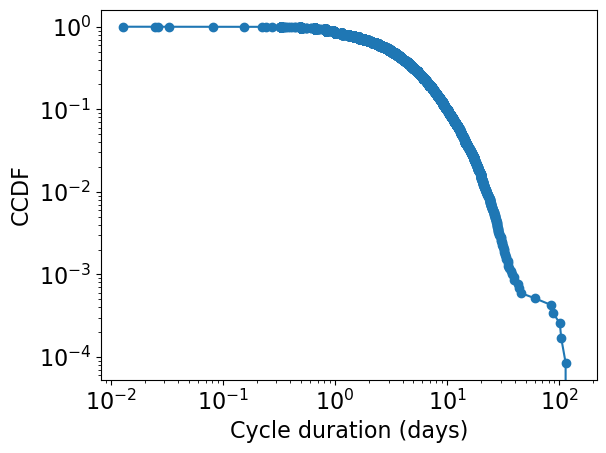

In [80]:
x,y = ccdf(data_df.duration_days)

fig, ax = plt.subplots()
ax.set_xscale("log")
ax.set_yscale("log")
ax.plot(x,y, marker="o")
ax.set_ylabel("CCDF")
ax.set_xlabel("Cycle duration (days)")

plt.show()

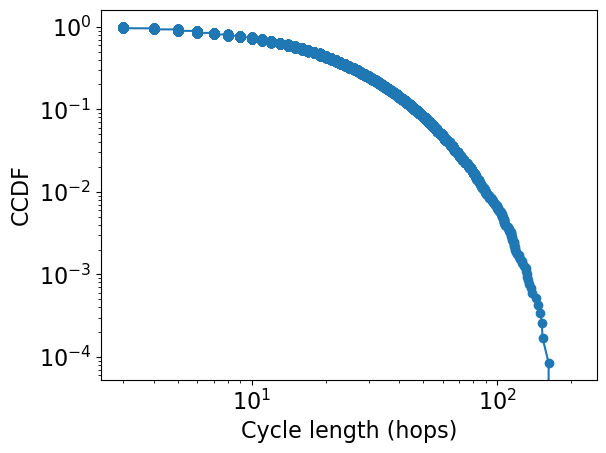

In [81]:
x,y = ccdf(data_df.length)

fig, ax = plt.subplots()
ax.set_xscale("log")
ax.set_yscale("log")
ax.plot(x,y, marker="o")
ax.set_ylabel("CCDF")
ax.set_xlabel("Cycle length (hops)")

plt.show()

## How many traders took part in cycles?

In [82]:
traders_profit = {}
for i, row in tqdm(data_df.iterrows()):
    cycle = eval(row['cycle_info'])
    trade = {
        'profit_usd': cycle['profit_usd'],
        'buyer':  cycle['buyer'],
        'cycle_size': row['cycle_lengths'],
        'nft_id': row['nft_id'],
        'cycle': cycle['cycle']['sales']
    }
    trader = trade['buyer']
    profit = trade['profit_usd']
    if trader not in traders_profit:
        traders_profit[trader] = []
    traders_profit[trader].append(profit)
traders_avg = {}
for trader, _profit in tqdm(traders_profit.items()):
    avg = sum(_profit)/len(_profit)
    traders_avg[trader] = {
        'avg': avg, 
        'count': len(_profit),
        'total_profit': sum(_profit)
    }
    
traders_count_sorted = sorted(traders_avg, key=lambda x: traders_avg[x]['count'], reverse=True)

for t in traders_count_sorted[:50]:
    print(t)
    print(traders_avg[t])
    print()

0it [00:00, ?it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

0x8acc1421ec98689461ff5777de8ad6648dc6d643
{'avg': 2.25195539174045, 'count': 617, 'total_profit': 1389.4564767038578}

0x00c9da65b33b4f7034b5f50b90f5f6d8320d6ab8
{'avg': 2.19609054383117, 'count': 616, 'total_profit': 1352.7917750000008}

0xa21e0974137bf8400eb7dca606d9dcb190d79ed9
{'avg': 2.3006426628664483, 'count': 614, 'total_profit': 1412.5945949999993}

0x838c14eb3eabe4cb6a696d286c7b2a466629d0ee
{'avg': 2.3572472385620915, 'count': 612, 'total_profit': 1442.63531}

0x1c1ef71445010114f41ac1feb32dbf5d7281e90f
{'avg': 2.347460337171051, 'count': 608, 'total_profit': 1427.255884999999}

0xe738725cdcc41c91f734dd7b5b9659df994d6dda
{'avg': 2.2413728476821193, 'count': 604, 'total_profit': 1353.7892000000002}

0x6a47b60c377450a460d3eb828d534ee66eead668
{'avg': 2.2968711341059587, 'count': 604, 'total_profit': 1387.310164999999}

0x463215edb66fb6a8f0c979e739a731977617699f
{'avg': 2.1705960117056864, 'count': 598, 'total_profit': 1298.0164150000005}

0x1e7f320cf5a938465d501f6bd6c405feb3a70

Above, we can see that 20 traders participated in over 528+ cycles each. 

Lets write some code to inspect these NFT cycles in more depth. 

The `pretty_cycle` function takes a cycle and prints out each subsequent trade and the profit and time between trades.  

In [83]:
def pretty_cycle(cycle):
    as_string = '   '
    prev_price = cycle[0]['price_usd']
    prev_time = cycle[0]['time']
    for item in cycle:
        diff = item['price_usd']-prev_price
        time_secs = item['time']-prev_time
        time_mins = time_secs/60
        time_hours = time_secs/60/60
        time_days = time_secs/60/60/24 
        prev_time = item['time']
        time_str = '%.1fm/%.1fh/%.2fd' % (time_mins, time_hours, time_days)
        as_string += 'T(d) '+time_str+', B: '+item['buyer'][:4]+'.. $'+str(item['price_usd'])+'('+str(diff)+') '+item['tx_hash']+'\n->'
    as_string = as_string[:-3]
    print(as_string)

# Lets take a look at the trader who did the most cycles

In [84]:
row

nft_id                                            50270009_Mycrypto
nft_collection                                             Mycrypto
nft_category                                                  Games
cycle_lengths                                                     3
cycle_info        {'cycle': {'sales': [{'price_usd': 681.1750000...
profit                                                      87.8125
min_ts                                                   1560997736
max_ts                                                   1561191785
length                                                            3
duration_days                                              2.245938
Name: 11703, dtype: object

In [85]:
largest_trader_addr = traders_count_sorted[0] # '0x8acc1421ec98689461ff5777de8ad6648dc6d643'
largest = []
for i, trade in tqdm(data_df.iterrows()):
    # ignore any rari tokens, as they are fractionalised
    #. ignore any short trades 
    if '_Rari' in trade['nft_id']:
        continue
    if eval(trade['cycle_info'])['buyer'] == largest_trader_addr:
        largest.append(trade)

0it [00:00, ?it/s]

#### Which NFTs did they trade?

In [86]:
from collections import Counter
most_common_nft_collection = []
most_common_nft = []
for trade in largest:
    nft_collection =  trade['nft_id'].split('_')
    most_common_nft.append(trade['nft_id'])
    most_common_nft_collection.append(nft_collection[1])
most_common_nft_collection = Counter(most_common_nft_collection)
most_common_nft = Counter(most_common_nft)
most_common_nft_collection

Counter({'Cryptokittie': 300, 'Mlbchampion': 136, 'Etheremon': 181})

#### What happens when we look at their cycles in more detail?

In [87]:
pretty_cycle(eval(largest[10]['cycle_info'])['cycle']['sales'])

   T(d) 0.0m/0.0h/0.00d, B: 0x8a.. $10.3494(0.0) 0x01247ccb317a80855278dcdc5c3537a5072d4a7a6140d2c317c261fc7bfecb0b
->T(d) 236.1m/3.9h/0.16d, B: 0x6e.. $10.3494(0.0) 0x01846b482c2557de84a069468c7bed8cc5640fe6d2aaa1c40b42c2b219ecfd1b
->T(d) 239.2m/4.0h/0.17d, B: 0x68.. $10.3494(0.0) 0xb2e0029ede8239175a61094eaae3ec6513aa2e4760ecfa28ce06ee756b75b5f8
->T(d) 234.4m/3.9h/0.16d, B: 0x17.. $10.3374(-0.011999999999998678) 0xadb28bb1bae8d2b76125b44c9ed15b6d43ff2398154386228cbd8d560e36217c
->T(d) 241.0m/4.0h/0.17d, B: 0x68.. $10.3374(-0.011999999999998678) 0x0dcb2ba42cf1656761e3b9e4827190d9440b54c4f3212fe94f49a176f7e7b16d
->T(d) 234.8m/3.9h/0.16d, B: 0xa2.. $10.3374(-0.011999999999998678) 0xc99839de6d2eb7e2fe59bb0007cb01454978af678bfa9565d3d01c54df381424
->T(d) 244.1m/4.1h/0.17d, B: 0xa3.. $10.3374(-0.011999999999998678) 0x7bbb188248a32fc07250f53b2afb6aef9c89e99c20454b6ab0e88f05c220e1e5
->T(d) 230.7m/3.8h/0.16d, B: 0xa2.. $10.3374(-0.011999999999998678) 0xa6c6235b212dc305415c85ccea5b2e979565640f

We have found something here, this trader trades each nft between wallets within a ~4 hour window??

#### What was the time between each transaction?

In [88]:
import math
def time_finder(cycle):
    prev_time = cycle[0]['time']
    times = []
    for sale in cycle:
        time_secs = sale['time']-prev_time
        time_hours = time_secs/60/60
        prev_time = sale['time']
        time_hours = round(time_hours, 1)
        times.append(time_hours)
    return times

time_found = []
for trade in largest:
    time_found.extend(time_finder(eval(trade['cycle_info'])['cycle']['sales']))
time_found = Counter(time_found)
print("total times : %i" % sum(time_found.values()))
between_39_41 = time_found[3.4]+time_found[3.5]+time_found[3.6] +time_found[3.7] +time_found[3.8] +time_found[3.9] +time_found[4.0] +time_found[4.1] +time_found[4.2]+time_found[4.3]+time_found[4.4]+time_found[4.5]+time_found[4.6]
print("times between 3.4 and 4.6 : %i - %.2fp" % (between_39_41, between_39_41/sum(time_found.values())*100))

total times : 13193
times between 3.4 and 4.6 : 11658 - 88.37p


#### Who did they trade with?

In [89]:
wallet_interactions = []
for trade in largest:
    for sale in eval(trade['cycle_info'])['cycle']['sales']:
        wallet_interactions.append(sale['buyer'])
wallet_interactions = Counter(wallet_interactions)
sorted(wallet_interactions.items(), key=lambda x: x[1], reverse=True), len(wallet_interactions)

([('0x8acc1421ec98689461ff5777de8ad6648dc6d643', 1234),
  ('0xa21e0974137bf8400eb7dca606d9dcb190d79ed9', 710),
  ('0x179d698f5a1c84c3ff4c5eb04e553c15a0c1d8d8', 674),
  ('0xe738725cdcc41c91f734dd7b5b9659df994d6dda', 662),
  ('0x1c1ef71445010114f41ac1feb32dbf5d7281e90f', 659),
  ('0x838c14eb3eabe4cb6a696d286c7b2a466629d0ee', 653),
  ('0xf5aee6d7b838d5ede8aa65d31dbc11116545180c', 649),
  ('0x6a47b60c377450a460d3eb828d534ee66eead668', 649),
  ('0xbabda06088c242fb2a763aa7cc99706cb77ba735', 644),
  ('0x00c9da65b33b4f7034b5f50b90f5f6d8320d6ab8', 635),
  ('0x463215edb66fb6a8f0c979e739a731977617699f', 624),
  ('0x1e7f320cf5a938465d501f6bd6c405feb3a70f6c', 623),
  ('0xa37e6b46fa8e1a6f1ddbf035c4e0230b8414ff04', 618),
  ('0x87b77fabfeb869150b8e1b9462603f9a639c5fae', 612),
  ('0x6e13c7e25c2cda6f5c8c4e431bee480bfb312c28', 600),
  ('0x236ef21dc36d0aec3990dd5ee84a9d5320644262', 596),
  ('0xadd12bd6375dc21d579cc4abcfa04864d6ac9a62', 594),
  ('0x7316e9cf94bef40d4981d66a5c41c38b6b32454c', 590),
  ('0x68d

Interestingly they only traded their NFTs with 20 other wallets. 

In [90]:
fellow_traders = list(wallet_interactions.keys())
for t in fellow_traders:
    print(t)
    print(traders_avg[t])
    print()

0x8acc1421ec98689461ff5777de8ad6648dc6d643
{'avg': 2.25195539174045, 'count': 617, 'total_profit': 1389.4564767038578}

0x236ef21dc36d0aec3990dd5ee84a9d5320644262
{'avg': 2.302746853448276, 'count': 580, 'total_profit': 1335.593175}

0x1e7f320cf5a938465d501f6bd6c405feb3a70f6c
{'avg': 2.2265507202680093, 'count': 597, 'total_profit': 1329.2507800000014}

0x179d698f5a1c84c3ff4c5eb04e553c15a0c1d8d8
{'avg': 2.278309740368508, 'count': 597, 'total_profit': 1360.1509149999993}

0x7316e9cf94bef40d4981d66a5c41c38b6b32454c
{'avg': 2.220082080291969, 'count': 548, 'total_profit': 1216.6049799999992}

0xa37e6b46fa8e1a6f1ddbf035c4e0230b8414ff04
{'avg': 2.1527055114638456, 'count': 567, 'total_profit': 1220.5840250000003}

0x838c14eb3eabe4cb6a696d286c7b2a466629d0ee
{'avg': 2.3572472385620915, 'count': 612, 'total_profit': 1442.63531}

0xe738725cdcc41c91f734dd7b5b9659df994d6dda
{'avg': 2.2413728476821193, 'count': 604, 'total_profit': 1353.7892000000002}

0x463215edb66fb6a8f0c979e739a731977617699f
{

All of these traders also participated in many cycles. 

#### What were the patterns of the fellow traders cycles?

In [91]:
import random

print(len(fellow_traders))

others_sibs = {}
for sibling in fellow_traders:
    others_sibs[sibling] = []
    for i,trade in data_df.iterrows():
        if '_Rari' in trade['nft_id']:
            continue
        if eval(trade['cycle_info'])['buyer'] == sibling:
            others_sibs[sibling].append(trade)
    print(sibling)
    rand = random.choice(range(0,len(others_sibs[sibling])))
    pretty_cycle(eval(others_sibs[sibling][rand]['cycle_info'])['cycle']['sales'])
    print()
    break

20
0x8acc1421ec98689461ff5777de8ad6648dc6d643
   T(d) 0.0m/0.0h/0.00d, B: 0x8a.. $20.443085000000004(0.0) 0x564a357899d524c6a4160002bc9c37f3f47feaf83a03090a2b4e308731fc6958
->T(d) 239.8m/4.0h/0.17d, B: 0xad.. $20.443085000000004(0.0) 0x929c8d3f856c8cc0c426a8baa981d486e64bfb2b76f0d7aff1acdd29ff31b8ca
->T(d) 1110.4m/18.5h/0.77d, B: 0x00.. $20.427875(-0.015210000000003276) 0xf67a6deb2754102077a4be56e8ba1538c29419d24119902c7472e1cab0037744
->T(d) 239.9m/4.0h/0.17d, B: 0xad.. $20.427875(-0.015210000000003276) 0xf78f525f93229a9be3738b9cf98e7c047cf99e54a30659cafc99e28ce22cfc73
->T(d) 234.2m/3.9h/0.16d, B: 0xf5.. $20.427875(-0.015210000000003276) 0x18521d5a474fcc7fef4e428d993d8c1ea5a42aa69729c05241ad3fbb9c6d62a4
->T(d) 240.1m/4.0h/0.17d, B: 0xba.. $20.427875(-0.015210000000003276) 0x5f0cc6764e7d8eb7a5f6d2fe73049706fe39c7d67e9ee5aa1e7f61e4362acc7f
->T(d) 709.9m/11.8h/0.49d, B: 0xf5.. $20.716020000000004(0.27293500000000037) 0x23e8e0907882da2bf186c7b8e6c6081732915dfab923550293732a9f22f46a88
->T(

All of these traders also follow the same, or a similar pattern.

Trading with each other, waiting ~4 hours before trading again. 